In [2]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models
from torch import optim
import torch

In [3]:
batch_size = 100
n_classes = 10
n_epochs = 20

In [4]:

image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [37]:
dataset = {
    'train': datasets.CIFAR100(
      root="data",
      #train=True,
      download=True,
      transform=image_transforms['train'],
    ),
    'test': datasets.CIFAR100(
      root="data",
      train=False,
      download=True,
      transform=image_transforms['test'],
    )
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(dataset['test'], batch_size=batch_size, shuffle=True)
}



Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [6]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([100, 3, 224, 224]), torch.Size([100]))

In [7]:
from torchvision import models
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
import torch.nn as nn

In [19]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512), 
                      nn.ReLU(),
                      nn.Linear(512, n_classes),
                      nn.ReLU()             
                  )

In [21]:
model = model.to('cuda')

In [22]:
#model = nn.DataParallel(model)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001)

In [25]:
losses = []
accuracies = []
r_a = []
r_l = []
model.train()
for epoch in range(n_epochs):
  it = 0
  for data, targets in dataloaders['train']:
    data = data.cuda()
    targets = targets.cuda()
    # Generate predictions
    
    out = model(data)
    # Calculate loss
    loss = criterion(out, targets)

    loss.backward()

    accr = (torch.argmax(out,axis=1) == targets).detach().sum().item() / batch_size
    accuracies.append(accr)
    losses.append( loss.item() )
    # Backpropagation
    # Update model parameters
    optimizer.step()
    if it % 20 == 19:
      r_a.append(sum(accuracies[-20:]) / 20)
      r_l.append(sum(losses[-20:]) / 20)
      print(epoch,it,r_a[-1],r_l[-1])
    it += 1


0 19 0.10900000000000001 2.295800507068634
0 39 0.279 2.2006343245506286
0 59 0.40599999999999997 1.958814400434494
0 79 0.44700000000000006 1.6923052787780761
0 99 0.5065000000000001 1.5540702044963837
0 119 0.5014999999999998 1.56315376162529
0 139 0.5205 1.4541680693626404
0 159 0.4965 1.5209032535552978
0 179 0.47050000000000003 1.6075876116752625
0 199 0.5145 1.5727158546447755
0 219 0.5480000000000002 1.528858983516693
0 239 0.5415000000000001 1.6257435083389282
0 259 0.542 1.5406576097011566
0 279 0.5370000000000001 1.4554105162620545
0 299 0.5235 1.438385397195816
0 319 0.577 1.3108704388141632
0 339 0.538 1.3654247999191285
0 359 0.5759999999999998 1.2788593828678132
0 379 0.567 1.2795242190361023
0 399 0.587 1.2531793713569641
0 419 0.6030000000000001 1.1773947834968568
0 439 0.5835 1.2552698314189912
0 459 0.584 1.246634840965271
0 479 0.5875000000000001 1.2223562061786652
0 499 0.611 1.1762943357229232
1 19 0.6070000000000001 1.194771808385849
1 39 0.572 1.2554709434509277


KeyboardInterrupt: ignored

In [26]:
import matplotlib.pyplot as plt

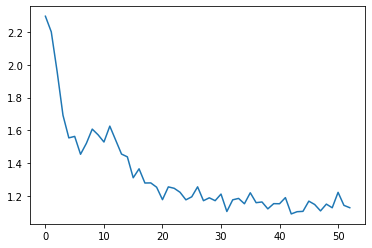

In [27]:
#loss per mini epoch
plt.plot(r_l)

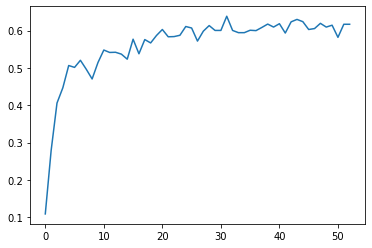

In [29]:
#accuracy per mini epoch
plt.plot(r_a)

In [36]:

model.eval()

cnt = 1
c_accr = 0
for data, targets in dataloaders['test']:
  break
  # Generate predictions
  data = data.cuda()
  targets = targets.cuda()
  out = model(data)


  accr = (torch.argmax(out,axis=1) == targets).sum().item() / batch_size
  c_accr += (accr)

  cnt+=1
c_accr /= cnt

print(c_accr)

0.56


In [ ]:
# Could not be trained enough only 2 epochs